In [1]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
from google.colab import drive 
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
df = pd.read_csv('/content/drive/MyDrive/mldata/wind_dataset.csv')  # read data to a dataframe

In [4]:
df[:3]

,DATE,WIND,IND,RAIN,IND.1,T.MAX,IND.2,T.MIN,T.MIN.G
0,1961-01-01,13.67,0,0.2,0.0,9.5,0.0,3.7,-1.0
1,1961-01-02,11.50,0,5.1,0.0,7.2,0.0,4.2,1.1
2,1961-01-03,11.25,0,0.4,0.0,5.5,0.0,0.5,-0.5


In [5]:
df[["YEAR","MONTH","DAY"]] = df["DATE"].str.split("-", expand = True).astype(int)  # create new columns "YEAR","MONTH" and "DAY" + change type to int

In [6]:
df[:3]

,DATE,WIND,IND,RAIN,IND.1,T.MAX,IND.2,T.MIN,T.MIN.G,YEAR,MONTH,DAY
0,1961-01-01,13.67,0,0.2,0.0,9.5,0.0,3.7,-1.0,1961,1,1
1,1961-01-02,11.50,0,5.1,0.0,7.2,0.0,4.2,1.1,1961,1,2
2,1961-01-03,11.25,0,0.4,0.0,5.5,0.0,0.5,-0.5,1961,1,3


In [7]:
df = df.drop(columns="DATE")  # drop column "DATE"

In [8]:
df[:3]

,WIND,IND,RAIN,IND.1,T.MAX,IND.2,T.MIN,T.MIN.G,YEAR,MONTH,DAY
0,13.67,0,0.2,0.0,9.5,0.0,3.7,-1.0,1961,1,1
1,11.50,0,5.1,0.0,7.2,0.0,4.2,1.1,1961,1,2
2,11.25,0,0.4,0.0,5.5,0.0,0.5,-0.5,1961,1,3


In [9]:
df.isna().sum()  # check if there are NaN(missing values)

WIND         0
IND          0
RAIN         0
IND.1       61
T.MAX      621
IND.2       61
T.MIN      674
T.MIN.G    360
YEAR         0
MONTH        0
DAY          0
dtype: int64

In [10]:
df_drop = df.dropna()  # create a new dataframe by dropping NaN
X_drop = df_drop.drop(columns="WIND")
y_drop = df_drop["WIND"]

In [11]:
means = df.mean()  # find means
means

WIND          9.796834
IND           0.391542
RAIN          1.885169
IND.1         0.356364
T.MAX        13.339123
IND.2         0.464456
T.MIN         6.411678
T.MIN.G       2.736547
YEAR       1969.500304
MONTH         6.523274
DAY          15.728628
dtype: float64

In [12]:
df_mean = df.fillna(means)  # create a new dataframe by filling NaN with means
X_mean = df_mean.drop(columns="WIND") # remove labels and non-relevant features
y_mean = df_mean["WIND"]

In [13]:
def create_dataset(X, y, split=0.8):  # function to split dataset
  idx = int(split*len(y))
  X_train, X_valid = X[:idx], X[idx:]
  y_train, y_valid = y[:idx], y[idx:]
  return [X_train, X_valid, y_train, y_valid]

In [14]:
def plot_error(data, start=10, end=500, tree=True, loss_func="squared_error"):  # function to plot an error as a function of min_samples_leaf
  mse = []
  samples = range(start,end)
  for s in samples:
    if tree:
      model = DecisionTreeRegressor(min_samples_leaf=s)
    else:
      model = RandomForestRegressor(n_estimators=10, min_samples_leaf=s, n_jobs=-1, criterion=loss_func)
    model.fit(data[0], data[2])
    y_pred = model.predict(data[1])
    mse.append(mean_squared_error(data[3], y_pred))
  plt.plot(samples, mse)

Text(0.5, 1.0, 'replaced vs. dropped')

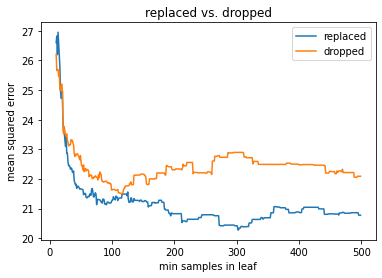

In [15]:
# compare datasets
plot_error(create_dataset(X_mean, y_mean))
plot_error(create_dataset(X_drop, y_drop))

plt.xlabel("min samples in leaf")
plt.ylabel("mean squared error")
plt.legend(['replaced', 'dropped'])
plt.title('replaced vs. dropped')

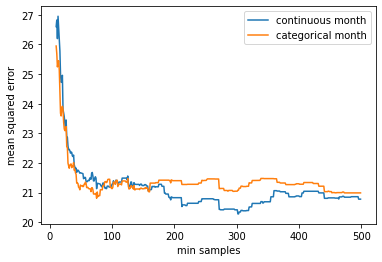

In [16]:
X_mean1 = pd.get_dummies(X_mean, columns=["MONTH"])  # make new dataset where the month is categorical
plot_error(create_dataset(X_mean, y_mean))
plot_error(create_dataset(X_mean1, y_mean))

plt.xlabel("min samples")
plt.ylabel("mean squared error")
plt.legend(['continuous month', 'categorical month'])

In [17]:
X_train, X_valid_test, y_train, y_valid_test = create_dataset(X_mean, y_mean, 0.8)  # split dataset into train and valid+test data
X_valid, X_test, y_valid, y_test = train_test_split(X_valid_test, y_valid_test, test_size=0.5, random_state=4)  # split dataset into valid and test randomly
[len(data) for data in [X_train, y_train, X_valid, y_valid, X_test, y_test]]

[5259, 5259, 657, 657, 658, 658]

In [18]:
model = DecisionTreeRegressor(min_samples_leaf=300)
model.fit(X_train, y_train)
y_pred_train = model.predict(X_train)
y_pred_valid = model.predict(X_valid)
y_pred_test = model.predict(X_test)

# check mean squared errors with decision tree
print('MSE_train:', mean_squared_error(y_train, y_pred_train))
print('MSE_valid:', mean_squared_error(y_valid, y_pred_valid))

MSE_train: 19.98744205278313
MSE_valid: 20.21004817315959


In [19]:
# Random Forest Regression
fr_reg = RandomForestRegressor(n_estimators=40, min_samples_leaf=200, n_jobs=-1, oob_score=True)
m_fr = fr_reg.fit(X_train, y_train)
y_pred_train = fr_reg.predict(X_train)
y_pred_valid = fr_reg.predict(X_valid)

mse_train = mean_squared_error(y_train, y_pred_train)
mse_valid = mean_squared_error(y_valid, y_pred_valid)
oob_error = mean_squared_error(m_fr.oob_prediction_, y_train)

print('MSE_train:', mse_train)
print('MSE_valid:', mse_valid)
print('OOB error:', oob_error)

MSE_train: 19.785581473758977
MSE_valid: 20.103642441828555
OOB error: 20.23990340544996


In [20]:
def rf_feature_importance(m, df):
    return pd.DataFrame({'feature':df.columns, 'importance':m.feature_importances_}
                       ).sort_values('importance', ascending=False)

In [21]:
# Feature importance for each feature used in the regression model
fi = rf_feature_importance(m_fr, X_train)
fi

,feature,importance
1,RAIN,0.373525
3,T.MAX,0.306964
6,T.MIN.G,0.179324
8,MONTH,0.086391
5,T.MIN,0.033455
7,YEAR,0.019294
9,DAY,0.001046
0,IND,0.000000
2,IND.1,0.000000
4,IND.2,0.000000


In [22]:
def find_innecessary_feature(train, valid, column):
  X_train_drop = train[0].drop(columns=column)
  X_valid_drop = valid[0].drop(columns=column)

  fr_reg = RandomForestRegressor(n_estimators=40, min_samples_leaf=200, n_jobs=-1, oob_score=True)
  fr_reg.fit(X_train_drop, train[1])
  y_pred_train = fr_reg.predict(X_train_drop)
  y_pred_valid = fr_reg.predict(X_valid_drop)

  mse_train = mean_squared_error(train[1], y_pred_train)
  mse_valid = mean_squared_error(valid[1], y_pred_valid)
  oob_error = mean_squared_error(m_fr.oob_prediction_, train[1])

  return mse_train, mse_valid

In [23]:
# find non-relevant features
features = ["DAY", 'IND', 'IND.1', 'IND.2']
print("Original :", mse_train, mse_valid)
for f in features:
  print(f, ":", find_innecessary_feature([X_train, y_train], [X_valid, y_valid], column=f))
print("All:", find_innecessary_feature([X_train, y_train], [X_valid, y_valid], column=features))

Original : 19.785581473758977 20.103642441828555
DAY : (19.70863333479895, 19.887272934521544)
IND : (19.722549867286464, 19.964367682865422)
IND.1 : (19.756743296645997, 20.021185238188597)
IND.2 : (19.747418923802314, 20.088745887484855)
All: (19.720036215304503, 19.97175673282197)


In [24]:
# remove non-relevant features
X_train_drop = X_train.drop(columns=["DAY", 'IND', 'IND.1', 'IND.2'])   
X_valid_drop = X_valid.drop(columns=["DAY", 'IND', 'IND.1', 'IND.2'])   
X_test_drop = X_test.drop(columns=["DAY", 'IND', 'IND.1', 'IND.2'])   

fr_reg = RandomForestRegressor(n_estimators=60, min_samples_leaf=200, n_jobs=-1, oob_score=True)
m_fr = fr_reg.fit(X_train_drop, y_train)   # fit model to training data 
y_pred_fr_train = fr_reg.predict(X_train_drop)
y_pred_fr_valid = fr_reg.predict(X_valid_drop)

# determine mean squared and root mean squared errors
print('MSE_fr_train:', mean_squared_error(y_train, y_pred_fr_train))
print('MSE_fr_valid:', mean_squared_error(y_valid, y_pred_fr_valid),'\n')

print('RMSE_fr_train:', np.sqrt(mean_squared_error(y_train, y_pred_fr_train)))
print('RMSE_fr_valid:', np.sqrt(mean_squared_error(y_valid, y_pred_fr_valid)), '\n')

# determine OOB error
print('OOB error:', np.sqrt(mean_squared_error(m_fr.oob_prediction_, y_train)))

MSE_fr_train: 19.759253719115872
MSE_fr_valid: 20.059996437560148 

RMSE_fr_train: 4.44513821147508
RMSE_fr_valid: 4.478838737614935 

OOB error: 4.495498877152856


In [25]:
# Feature importance for each feature used in the regression model after dropping
fi = rf_feature_importance(m_fr, X_train_drop)
fi

,feature,importance
0,RAIN,0.376521
1,T.MAX,0.304962
3,T.MIN.G,0.188822
5,MONTH,0.082317
2,T.MIN,0.026880
4,YEAR,0.020497


In [26]:
df.tail(3)

,WIND,IND,RAIN,IND.1,T.MAX,IND.2,T.MIN,T.MIN.G,YEAR,MONTH,DAY
6571,19.17,0,14.7,0.0,5.0,0.0,3.5,3.2,1978,12,29
6572,18.08,0,4.9,0.0,2.9,0.0,0.3,-0.5,1978,12,30
6573,19.25,0,0.5,0.0,1.2,1.0,-1.5,-3.0,1978,12,31


Text(0, 0.5, 'mean squared error')

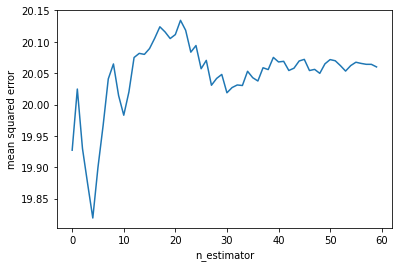

In [27]:
# plot MSE as a function of the number of trees used in the Random Forest Regression model
preds = np.stack([t.predict(X_valid_drop.values) for t in m_fr.estimators_])
plt.plot([mean_squared_error(preds[:i+1].mean(0), y_valid) for i in range(60)]);

plt.xlabel("n_estimator")
plt.ylabel("mean squared error")

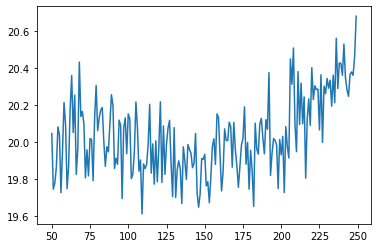

In [28]:
plot_error([X_train_drop, X_valid_drop, y_train, y_valid], 50, 250, tree=False)  # find optimal min_samples_leaf in random forest

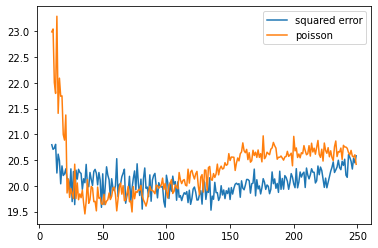

In [29]:
# compare loss functions
plot_error([X_train_drop, X_valid_drop, y_train, y_valid], 10, 250, tree=False)
plot_error([X_train_drop, X_valid_drop, y_train, y_valid], 10, 250, tree=False, loss_func="poisson")
plt.legend(["squared error", "poisson"])

In [30]:
# determine MSE with optimal parameters (RF)

rf_reg = RandomForestRegressor(n_estimators=30, min_samples_leaf=130, n_jobs=-1, oob_score=True, random_state=12)
rf_reg.fit(X_train_drop, y_train)

y_pred_train_rf = rf_reg.predict(X_train_drop)
y_pred_valid_rf = rf_reg.predict(X_valid_drop)
y_pred_test_rf = rf_reg.predict(X_test_drop)

rf_preds = [y_pred_train_rf, y_pred_valid_rf, y_pred_test_rf]

print('MSE_train:', mean_squared_error(y_train, y_pred_train_rf))
print('MSE_valid:', mean_squared_error(y_valid, y_pred_valid_rf))
print('OOB error:', mean_squared_error(m_fr.oob_prediction_, y_train))

MSE_train: 19.010570088230093
MSE_valid: 19.766387265192222
OOB error: 20.20951015448259


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


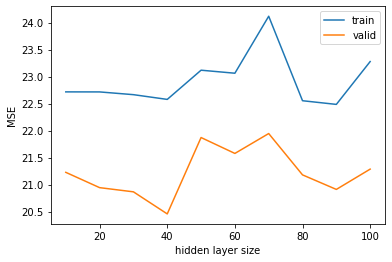

In [31]:
mse1 = []
mse2 = []
x = [10,20,30,40,50,60,70,80,90,100]

# determine the best hidden layer size
for h in x:
  mlp_reg = MLPRegressor(hidden_layer_sizes=h, learning_rate='adaptive', max_iter=200, random_state=4)
  mlp_reg.fit(X_train_drop, y_train)
  y_pred_train_mlp = mlp_reg.predict(X_train_drop)
  y_pred_valid_mlp = mlp_reg.predict(X_valid_drop)
  mse1.append(mean_squared_error(y_train, y_pred_train_mlp))
  mse2.append(mean_squared_error(y_valid, y_pred_valid_mlp))

plt.plot(x, mse1)
plt.plot(x, mse2)
plt.xlabel("hidden layer size")
plt.ylabel("MSE")
plt.legend(['train', 'valid'])

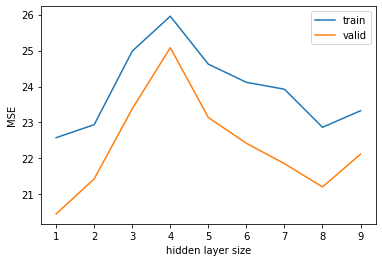

In [32]:
mse1 = []
mse2 = []
x = range(1,10)

# determine the best amount of layers
for i in x:
  mlp_reg = MLPRegressor(hidden_layer_sizes=([40]*i), learning_rate='adaptive', max_iter=200, random_state=4)
  mlp_reg.fit(X_train_drop, y_train)
  y_pred_train_mlp = mlp_reg.predict(X_train_drop)
  y_pred_valid_mlp = mlp_reg.predict(X_valid_drop)
  mse1.append(mean_squared_error(y_train, y_pred_train_mlp))
  mse2.append(mean_squared_error(y_valid, y_pred_valid_mlp))

plt.plot(x, mse1)
plt.plot(x, mse2)
plt.xlabel("hidden layer size")
plt.ylabel("MSE")
plt.legend(['train', 'valid'])

In [33]:
  # determine MSE with optimal parameters (MLP)
  mlp_reg = MLPRegressor(hidden_layer_sizes=40, learning_rate='adaptive', max_iter=200, random_state=4)
  mlp_reg.fit(X_train_drop, y_train)

  y_pred_train_mlp = mlp_reg.predict(X_train_drop)
  y_pred_valid_mlp = mlp_reg.predict(X_valid_drop)
  y_pred_test_mlp = mlp_reg.predict(X_test_drop)
  mlp_preds = [y_pred_train_mlp, y_pred_valid_mlp, y_pred_test_mlp]

In [34]:
labels = [y_train, y_valid, y_test]

In [35]:
# compare errors between the models
mlp_error = [mean_squared_error(labels[i], mlp_preds[i]) for i in range(3)]
rf_error = [mean_squared_error(labels[i], rf_preds[i]) for i in range(3)]
mix_error = [mean_squared_error(labels[i], (2*rf_preds[i]+mlp_preds[i])/3) for i in range(3)]

errors = np.array([mlp_error, rf_error, mix_error]).T
pd.DataFrame(errors, columns=["MLP", "RF", "MIX"], index=["train", "valid", "test"])

,MLP,RF,MIX
train,22.577651,19.010570,19.559943
valid,20.457684,19.766387,19.393720
test,21.016732,20.163033,19.820164


In [36]:
corr_matrix = df.corr()
corr_matrix["WIND"].sort_values(ascending=False)

WIND       1.000000
RAIN       0.120876
IND.1      0.070512
IND.2      0.047860
T.MIN.G    0.012823
DAY        0.000502
IND       -0.038578
MONTH     -0.066635
YEAR      -0.069690
T.MIN     -0.093014
T.MAX     -0.242559
Name: WIND, dtype: float64